# Code Flow for Training Data

## Observing the Training Data Pattern through Scatter Plots

### Importing requiered Libraries for Visualisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### Importing Data from Folder

In [2]:
data_dir_visualize = r"S:\Nit Durgapur\College 4th Sem\JU Internship\Fins Heat Prediction\2D Data\Visualize Data"
bt_folders_visualize = ['B.T. 320', 'B.T. 330', 'B.T. 340', 'B.T. 350', 'B.T. 360', 'B.T. 370', 'B.T. 380', 'B.T. 390', 'B.T. 400']

### Concatenating Data into a Single DataFrame

In [3]:
all_temp_data = [] # Empty list to hold all temperature data

# Loop over folders
for folder in bt_folders_visualize:
    folder_path = os.path.join(data_dir_visualize, folder)
    
    # Search for temp.csv file inside the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('temp.csv'):
            file_path = os.path.join(folder_path, filename)
            df_visualize = pd.read_csv(file_path)
            df_visualize.columns = ['x', 'y', 'Temperature'] 
            df_visualize['BT'] = int(folder.split('.')[-1]) # Creating the B.T. column
            all_temp_data.append(df_visualize)

# Combine all
df_visualize = pd.concat(all_temp_data, ignore_index = True)

In [4]:
df_visualize.shape

(3129786, 4)

In [5]:
df_visualize.head(139100)

,x,y,Temperature,BT
0,0.096000,0.180003,300.0,320
1,0.096002,0.181001,300.0,320
2,0.095002,0.181004,300.0,320
3,0.094999,0.180003,300.0,320
4,0.095999,0.182005,300.0,320
...,...,...,...,...
139095,0.014000,0.190000,300.0,320
139096,0.014000,0.191000,300.0,320
139097,0.014000,0.192000,300.0,320
139098,0.014000,0.193000,300.0,320


In [6]:
bt_value = 350
df_bt = df_visualize[df_visualize['BT'] == bt_value]

plt.figure(figsize = (10, 6))
plt.scatter(df_bt['x'], df_bt['y'], c = df_bt['Temperature'], cmap = 'coolwarm', s = 1)
plt.colorbar(label = 'Temperature')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

### Scatter Plot of all the Body Temperatures with Temperature Variation

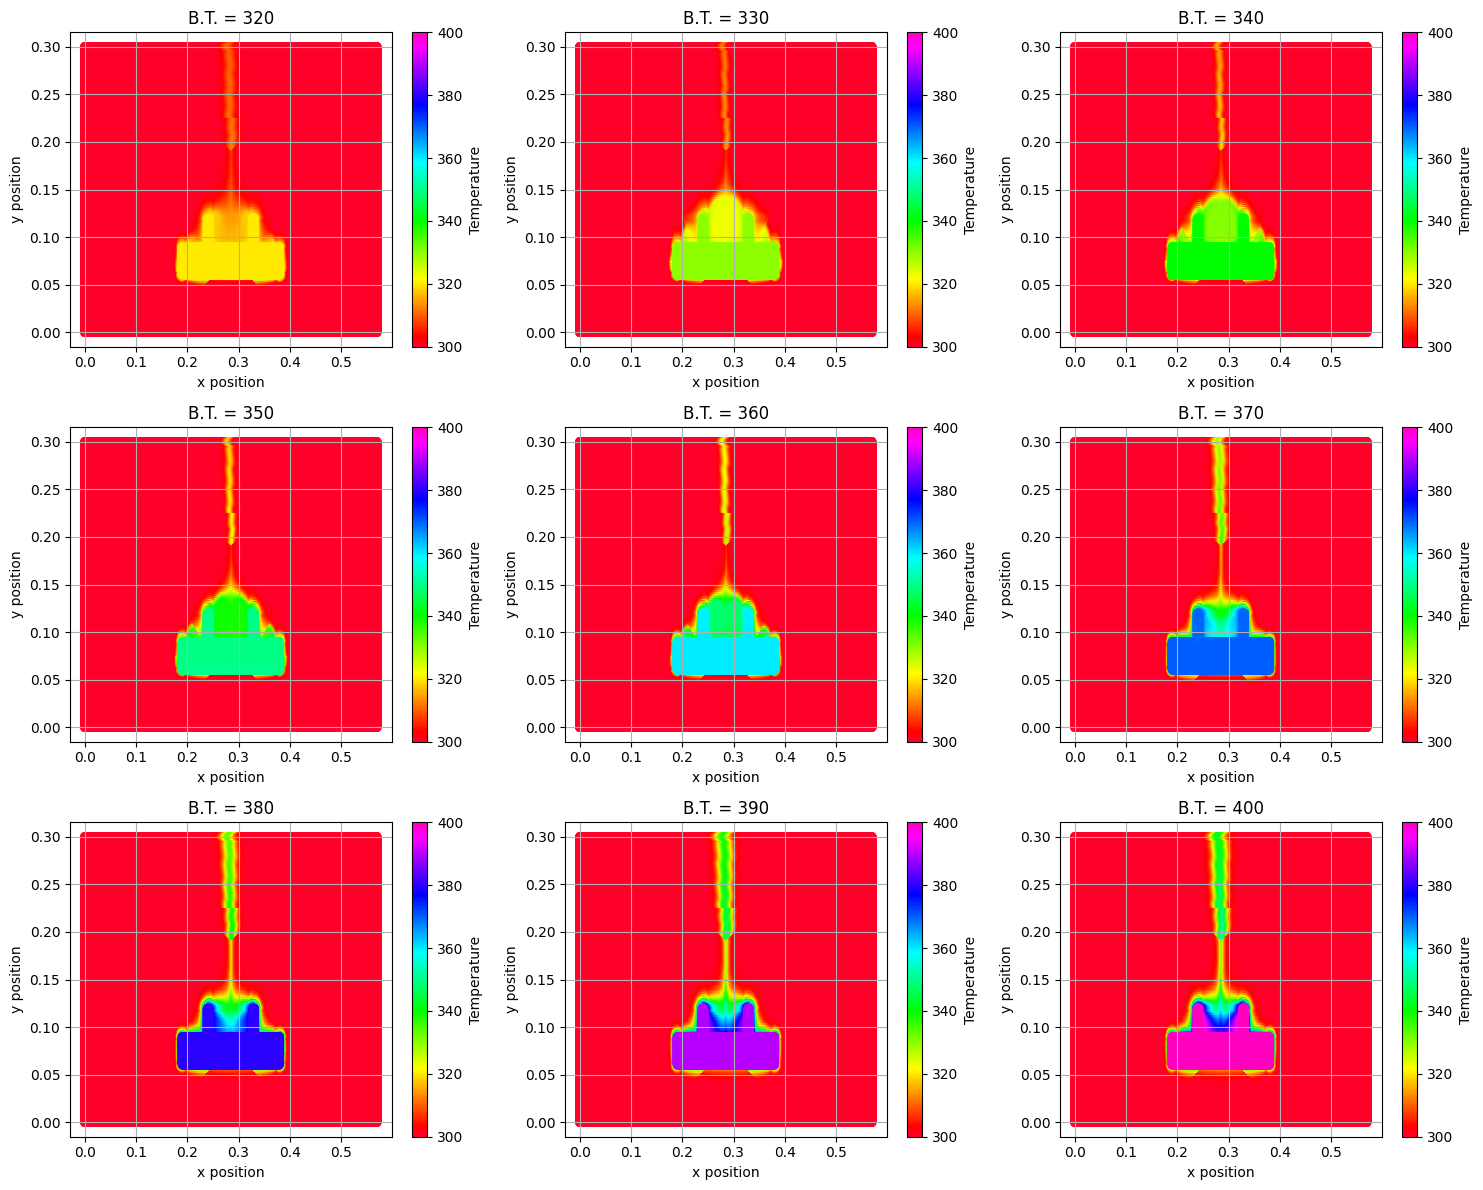

In [ ]:
# Get unique boundary conditions sorted
unique_bcs = sorted(df_visualize['BT'].unique())

# Set up subplots
n_cols = 3
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize = (15, 12))
axes = axes.flatten() # Flatten the 2D array of axes to 1D array

# Loop through B.T.s and plot
for idx, bt_val in enumerate(unique_bcs):
    df_bt = df_visualize[df_visualize['BT'] == bt_val]
    
    ax = axes[idx]
    scatter = ax.scatter(
        df_bt['x'], 
        df_bt['y'], 
        c = df_bt['Temperature'], 
        cmap = 'gist_rainbow', 
        s = 30, 
        vmin = df_visualize['Temperature'].min(), 
        vmax = df_visualize['Temperature'].max()
    )
    ax.set_title(f'B.T. = {bt_val}')
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.grid(True)
    cbar = fig.colorbar(scatter, ax = ax)
    cbar.set_label('Temperature')

plt.tight_layout()
plt.show()

# Importing data for Training the model

In [ ]:
data_dir_train = r"S:\Nit Durgapur\College 4th Sem\JU Internship\Fins Heat Prediction\2D Data\Training Data"
bt_folders_train = ['B.T. 320', 'B.T. 330', 'B.T. 340', 'B.T. 360', 'B.T. 380', 'B.T. 390', 'B.T. 400']

In [ ]:
all_temp_data = [] # Empty list to hold all temperature data

# Loop over folders
for folder in bt_folders_train:
    folder_path = os.path.join(data_dir_visualize, folder)
    
    # Search for temp.csv file inside the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('temp.csv'):
            file_path = os.path.join(folder_path, filename)
            df_train = pd.read_csv(file_path)
            df_train.columns = ['x', 'y', 'Temperature'] 
            df_train['BT'] = int(folder.split('.')[-1]) # Creating the B.T. column
            all_temp_data.append(df_train)

# Combine all
df_train = pd.concat(all_temp_data, ignore_index = True)

In [ ]:
df_train.shape

(2434278, 4)

In [ ]:
df_train.head

<bound method NDFrame.head of                 x         y  Temperature   BT
0        0.096000  0.180003        300.0  320
1        0.096002  0.181001        300.0  320
2        0.095002  0.181004        300.0  320
3        0.094999  0.180003        300.0  320
4        0.095999  0.182005        300.0  320
...           ...       ...          ...  ...
2434273  0.000000  0.297000        300.0  400
2434274  0.000000  0.298000        300.0  400
2434275  0.000000  0.299000        300.0  400
2434276  0.000000  0.300000        300.0  400
2434277  0.001000  0.300000        300.0  400

[2434278 rows x 4 columns]>

### Saving the Training Data

In [ ]:
file_path = r"S:\Nit Durgapur\College 4th Sem\JU Internship\Fins Heat Prediction\2D Data\Actual_Training_Data.csv"
df_train.to_csv(file_path, index = False)

## Training and Testing Data Preparation

### Importing requiered Libraries for Training Data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tensorflow.keras.utils import plot_model

### Splitting Data into X and y

In [ ]:
X = df_train[['x', 'y', 'BT']].values # Input parameters
y = df_train['Temperature'].values # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

x_scaler = StandardScaler() # RobustScaler() # Used for outliers
# MinMaxScaler() or StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [ ]:
X_train.shape, X_train_scaled.shape

((1947422, 3), (1947422, 3))

In [ ]:
X_test.shape, X_test_scaled.shape

((486856, 3), (486856, 3))

In [ ]:
y_train.shape, y_train_scaled.shape

((1947422,), (1947422,))

In [ ]:
y_test.shape, y_test_scaled.shape

((486856,), (486856,))

In [ ]:
X_train_scaled.min(), X_train_scaled.max(), y_train.min(), y_train.max()

(-1.7310430340349543, 1.7310172762153662, 300.0, 400.0)

### Building the ANN Model

In [ ]:
def huber_loss(y_true, y_pred, delta = 1.35):
    error = y_true - y_pred
    condition = tf.abs(error) <= delta
    squared_loss = 0.5 * tf.square(error)
    linear_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(condition, squared_loss, linear_loss)

In [ ]:
model = Sequential([
    Dense(256, activation = 'swish', input_shape = (X_train_scaled.shape[1], )), # Input layer
    BatchNormalization(), 
    Dense(128, activation = 'swish'),
    BatchNormalization(),
    Dense(64, activation = 'swish'),
    Dropout(0.2),
    Dense(32, activation = 'swish'),
    BatchNormalization(),
    Dense(16, activation = 'swish'),
    BatchNormalization(),
    Dense(1, activation = 'linear')
])

optimizer = Adam(learning_rate = 0.001, clipnorm = 1.0)
model.compile(optimizer = optimizer, loss = huber_loss, metrics = [huber_loss, 'mae'])

early_stop = EarlyStopping(patience = 10, min_delta = 0.001, restore_best_weights = True)
reduce_rl = ReduceLROnPlateau(factor = 0.5, patience = 10, min_lr = 1e-6)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1024      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0

In [ ]:
model.fit(X_train_scaled, y_train_scaled, validation_data = (X_test_scaled, y_test_scaled), epochs = 30, batch_size = 64, callbacks = [reduce_rl, early_stop])

Epoch 1/30
30429/30429 [==============================] - 85s 3ms/step - loss: 0.0877 - huber_loss: 0.0877 - mae: 0.2007 - val_loss: 0.0220 - val_huber_loss: 0.0220 - val_mae: 0.0738 - lr: 0.0010
Epoch 2/30
30429/30429 [==============================] - 90s 3ms/step - loss: 0.0437 - huber_loss: 0.0437 - mae: 0.1515 - val_loss: 0.0187 - val_huber_loss: 0.0187 - val_mae: 0.0641 - lr: 0.0010
Epoch 3/30
30429/30429 [==============================] - 83s 3ms/step - loss: 0.0359 - huber_loss: 0.0359 - mae: 0.1426 - val_loss: 0.0144 - val_huber_loss: 0.0144 - val_mae: 0.0626 - lr: 0.0010
Epoch 4/30
30429/30429 [==============================] - 81s 3ms/step - loss: 0.0313 - huber_loss: 0.0313 - mae: 0.1374 - val_loss: 0.0124 - val_huber_loss: 0.0124 - val_mae: 0.0765 - lr: 0.0010
Epoch 5/30
30429/30429 [==============================] - 76s 3ms/step - loss: 0.0286 - huber_loss: 0.0286 - mae: 0.1343 - val_loss: 0.0193 - val_huber_loss: 0.0193 - val_mae: 0.0653 - lr: 0.0010
Epoch 6/30
30429/304

In [ ]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

15215/15215 [==============================] - 15s 966us/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print("Final MAE in Kelvin:", mae)

Final MAE in Kelvin: 0.48774256769074364


## Importing data for Prediction

In [ ]:
pred_data_dir = r"S:\Nit Durgapur\College 4th Sem\JU Internship\Fins Heat Prediction\2D Data\Prediction Data"
pred_bt_folders = ['B.T. 370', 'B.T. 350']

In [ ]:
all_temp_data = [] # Empty list to hold all temperature data

# Loop over folders
for folder in pred_bt_folders:
    folder_path = os.path.join(pred_data_dir, folder)
    
    # Search for temp.csv file inside the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('temp.csv'):
            file_path = os.path.join(folder_path, filename)
            
            df_pred = pd.read_csv(file_path)
            df_pred.columns = ['x', 'y', 'Temperature'] 
            df_pred['BT'] = int(folder.split('.')[-1]) # Creating the B.T. column
            all_temp_data.append(df_pred)

# Combine all
df_pred = pd.concat(all_temp_data, ignore_index = True)

In [ ]:
df_pred.shape

(695508, 4)

In [ ]:
df_pred.head(30000)

,x,y,Temperature,BT
0,0.096000,0.180003,300.0,370
1,0.096002,0.181001,300.0,370
2,0.095002,0.181004,300.0,370
3,0.094999,0.180003,300.0,370
4,0.095999,0.182005,300.0,370
...,...,...,...,...
29995,0.159996,0.219000,300.0,370
29996,0.160996,0.219000,300.0,370
29997,0.158996,0.219000,300.0,370
29998,0.157996,0.219000,300.0,370


In [ ]:
# Prepare input features
X_pred = df_pred[['x', 'y', 'BT']].values
X_pred_scaled = x_scaler.transform(X_pred)

# Actual temperature
y_actual = df_pred['Temperature'].values

# Predict
y_pred_scaled = model.predict(X_pred_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()

# Calculate absolute and relative error
abs_error = np.abs(y_actual - y_pred)
rel_error = (abs_error / np.abs(y_actual)) * 100 # Relative error in percentage

# Add predicted and error to DataFrame
df_pred['Predicted_Temperature'] = y_pred
df_pred['Absolute_Error'] = abs_error
df_pred['Relative_Error'] = rel_error

21735/21735 [==============================] - 22s 1ms/step


In [ ]:
df_pred.shape

(695508, 7)

In [ ]:
df_pred.head(30000)

,x,y,Temperature,BT,Predicted_Temperature,Absolute_Error,Relative_Error
0,0.096000,0.180003,300.0,370,300.189697,0.189697,0.063232
1,0.096002,0.181001,300.0,370,300.189972,0.189972,0.063324
2,0.095002,0.181004,300.0,370,300.190979,0.190979,0.063660
3,0.094999,0.180003,300.0,370,300.190704,0.190704,0.063568
4,0.095999,0.182005,300.0,370,300.190186,0.190186,0.063395
...,...,...,...,...,...,...,...
29995,0.159996,0.219000,300.0,370,300.303223,0.303223,0.101074
29996,0.160996,0.219000,300.0,370,300.303833,0.303833,0.101278
29997,0.158996,0.219000,300.0,370,300.302490,0.302490,0.100830
29998,0.157996,0.219000,300.0,370,300.301697,0.301697,0.100566


## Saving the Predicted data with Absolute Error & Relative Error

In [ ]:
output_path = r"S:\Nit Durgapur\College 4th Sem\JU Internship\Fins Heat Prediction\2D Data\Predicted_With_Error.csv"
df_pred.to_csv(output_path, index = False)

## Plot of Predicted Temperature with X and Y Coordinates

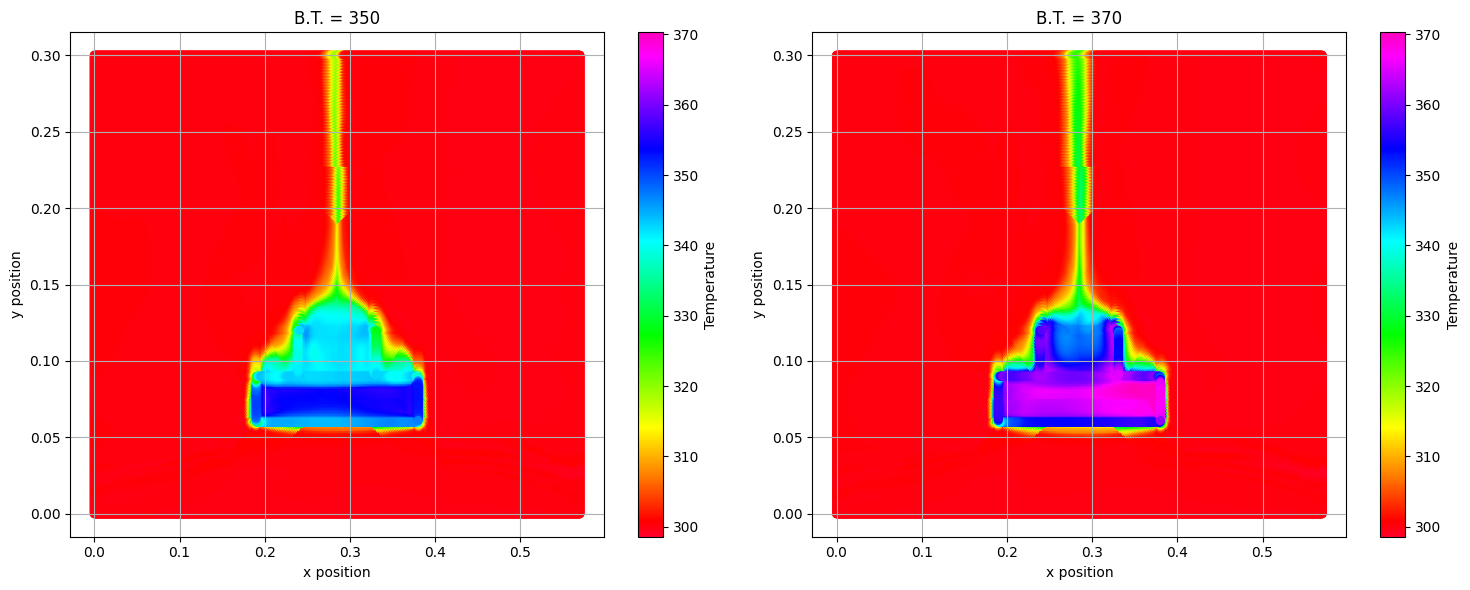

In [ ]:
# Get unique boundary conditions sorted
unique_bcs = sorted(df_pred['BT'].unique())

# Set up subplots
n_cols = 2
n_rows = 1

fig, axes = plt.subplots(n_rows, n_cols, figsize = (15, 6))
axes = axes.flatten() # Flatten the 2D array of axes to 1D array

# Loop through B.C.s and plot
for idx, bt_val in enumerate(unique_bcs):
    df_bt = df_pred[df_pred['BT'] == bt_val]
    
    ax = axes[idx]
    scatter = ax.scatter(
        df_bt['x'], 
        df_bt['y'], 
        c = df_bt['Predicted_Temperature'], 
        cmap = 'gist_rainbow', 
        s = 30,
        vmin = df_pred['Predicted_Temperature'].min(),
        vmax = df_pred['Predicted_Temperature'].max()
    )
    ax.set_title(f'B.T. = {bt_val}')
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.grid(True)
    cbar = fig.colorbar(scatter, ax = ax)
    cbar.set_label('Temperature')

plt.tight_layout()
plt.show()

## Actual Temperature vs Predicted Temperature Plot

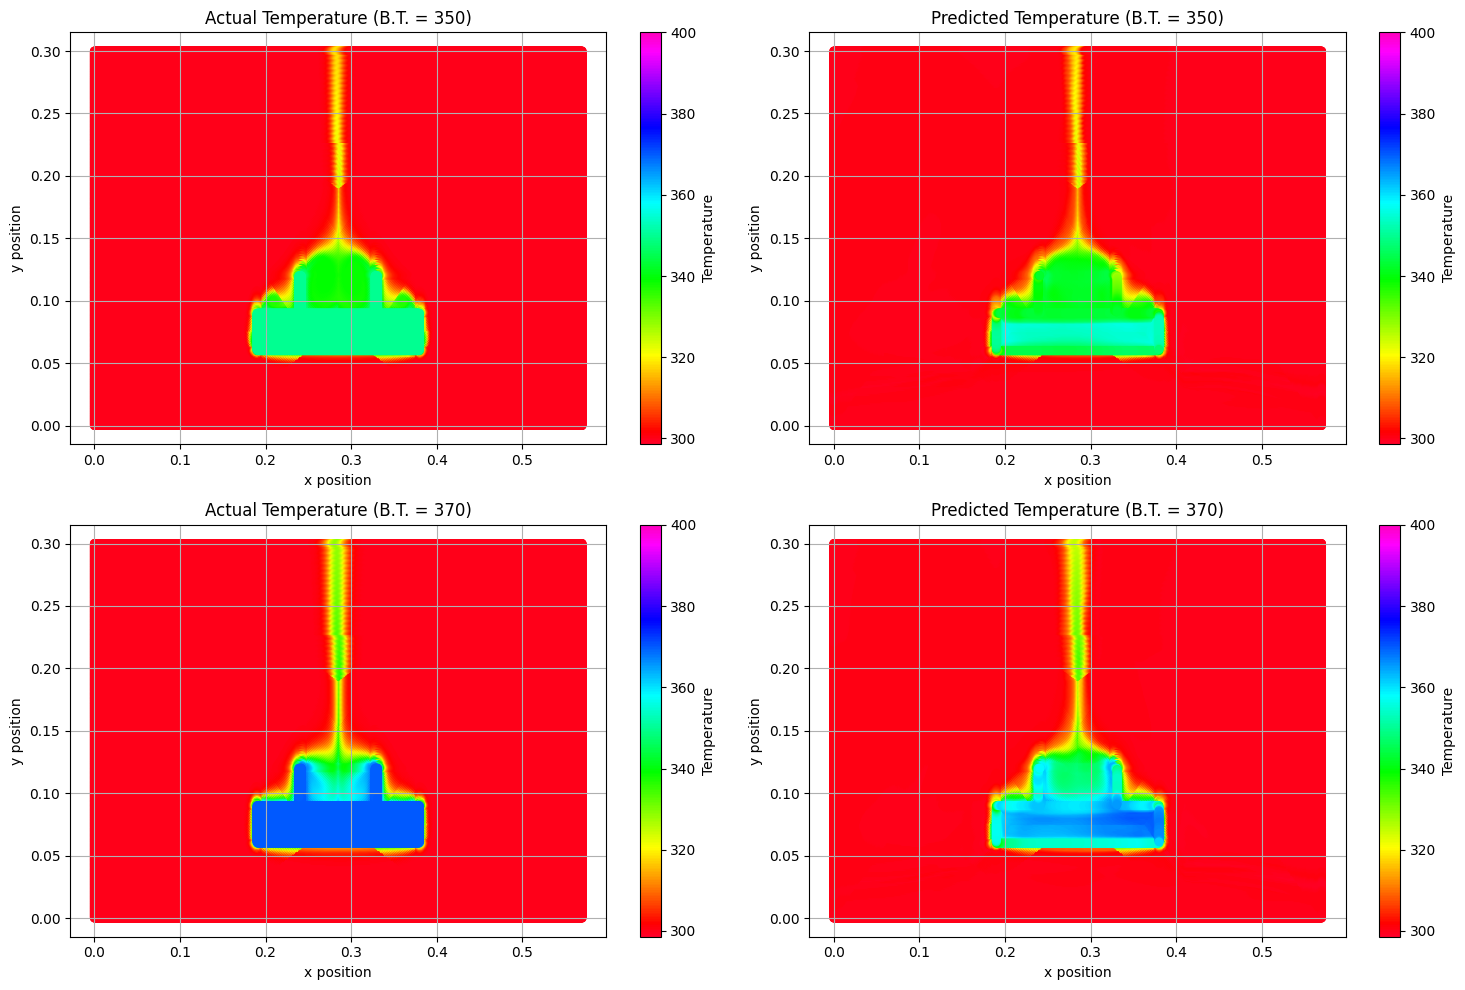

In [ ]:
unique_bcs = sorted(df_pred['BT'].unique())

fig, axes = plt.subplots(len(unique_bcs), 2, figsize = (15, 10))

vmin = min(df_visualize['Temperature'].min(), df_pred['Predicted_Temperature'].min())
vmax = max(df_visualize['Temperature'].max(), df_pred['Predicted_Temperature'].max())

for row_idx, bt_val in enumerate(unique_bcs):
    df_actual_bt = df_visualize[df_visualize['BT'] == bt_val]
    df_pred_bt = df_pred[df_pred['BT'] == bt_val]

    # Left Plot -> Actual Temperature
    scatter_actual = axes[row_idx, 0].scatter(
        df_actual_bt['x'], 
        df_actual_bt['y'], 
        c = df_actual_bt['Temperature'], 
        cmap = 'gist_rainbow', 
        s = 30,
        vmin = vmin,
        vmax = vmax
    )
    axes[row_idx, 0].set_title(f'Actual Temperature (B.T. = {bt_val})')
    axes[row_idx, 0].set_xlabel('x position')
    axes[row_idx, 0].set_ylabel('y position')
    axes[row_idx, 0].grid(True)
    fig.colorbar(scatter_actual, ax = axes[row_idx, 0]).set_label('Temperature')
    
    # Right Plot -> Predicted Temperature
    scatter_pred = axes[row_idx, 1].scatter(
        df_pred_bt['x'], 
        df_pred_bt['y'], 
        c = df_pred_bt['Predicted_Temperature'], 
        cmap = 'gist_rainbow', 
        s = 30,
        vmin = vmin,
        vmax = vmax
    )
    axes[row_idx, 1].set_title(f'Predicted Temperature (B.T. = {bt_val})')
    axes[row_idx, 1].set_xlabel('x position')
    axes[row_idx, 1].set_ylabel('y position')
    axes[row_idx, 1].grid(True)
    fig.colorbar(scatter_pred, ax = axes[row_idx, 1]).set_label('Temperature')

plt.tight_layout()
plt.show()

## Plot of Absolute Error

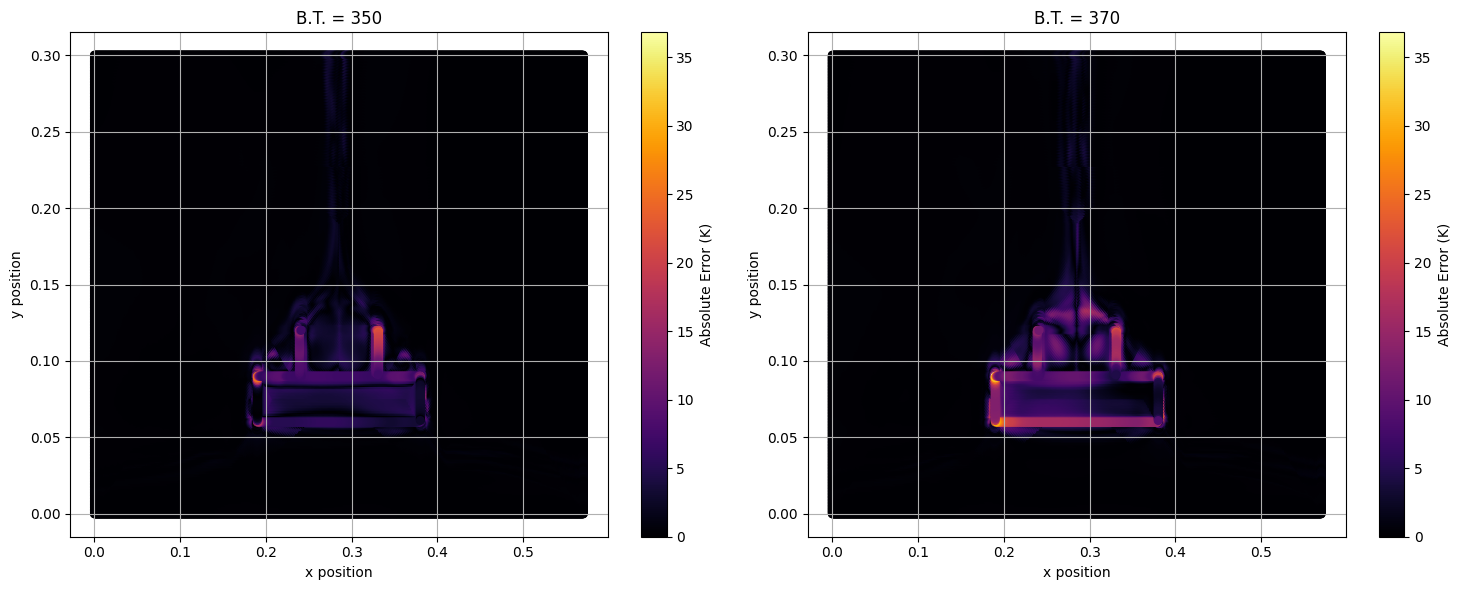

In [ ]:
# Get unique boundary conditions sorted
unique_bcs = sorted(df_pred['BT'].unique())

# Set up subplots
n_cols = 2
n_rows = 1

fig, axes = plt.subplots(n_rows, n_cols, figsize = (15, 6))
axes = axes.flatten() # Flatten the 2D array of axes to 1D array

# Loop through B.C.s and plot
for idx, bt_val in enumerate(unique_bcs):
    df_bt = df_pred[df_pred['BT'] == bt_val]
    
    ax = axes[idx]
    scatter = ax.scatter(
        df_bt['x'], 
        df_bt['y'], 
        c = df_bt['Absolute_Error'], 
        cmap = 'inferno', 
        s = 30,
        vmin = df_pred['Absolute_Error'].min(),
        vmax = df_pred['Absolute_Error'].max()
    )
    ax.set_title(f'B.T. = {bt_val}')
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.grid(True)
    cbar = fig.colorbar(scatter, ax = ax)
    cbar.set_label('Absolute Error (K)')

plt.tight_layout()
plt.show()